In [72]:
import numpy as np
import matplotlib.pyplot as plt
from models.training import easyTrainer, weights_to_dataset
from models.nODE import nODE, make_nODE_from_parameters
import scipy
import torch

In [4]:
# 5D repressilator

In [91]:
dim = 7

gamma = - np.ones([dim])
Wout = 2 * np.eye(dim)
Win = np.zeros([dim, dim])
for i in range(dim - 1):
    Win[i, i + 1] = -1
Win[dim - 1, 0] = -1
bin, bout = 2 * np.ones([dim, 1]), 2 * np.ones([dim, 1])

node_5Drepr = make_nODE_from_parameters(gamma, Win=Win, bin=bin, Wout=Wout, bout=bout)


In [ ]:
# generate random networks on 2 nodes

In [101]:
rng1 = np.random.default_rng()
rng1.standard_normal([2,2])

array([[0.11899321, 1.44942017],
       [0.79702904, 2.00677987]])

In [154]:
def rand_dim(dim):
    return rng1.standard_normal(dim)

In [155]:
def adjacency_matrix(W):
    if isinstance(W,np.ndarray):
        W = torch.from_numpy(W)
    values_log_W = torch.sort(torch.log(torch.abs(W.flatten())))[0]
    threshold = values_log_W[torch.sort(values_log_W[1:] - values_log_W[:-1])[1][-1] + 1]
    W_bool_activation = (W >= torch.exp(threshold))
    W_bool_repr = (W <= -torch.exp(threshold))
    adjacency_mat = W_bool_activation.float() - W_bool_repr.float()
    return adjacency_mat

In [156]:
def random_zeros(mat, threshold = 0.7):
    rand_mat = np.random.uniform(size = np.shape(mat))
    bool_mask = rand_mat > threshold
    return np.multiply(mat, bool_mask)

In [188]:
def randomize_adjacency(adjacency, threshold = 0.7):
    noisy_adjacency = np.abs(adjacency)
    flipped_adjacency = -1 + noisy_adjacency

    # randomly remove  connections
    rand_mat = np.random.uniform(size = np.shape(adjacency))
    bool_mask = rand_mat > (1-threshold)
    print(bool_mask)
    noisy_adjacency = np.multiply(noisy_adjacency, bool_mask)
    print(noisy_adjacency)
    
    #randomly add unwanted connections
    rand_mat = np.random.uniform(size = np.shape(adjacency))
    bool_mask = rand_mat > threshold    
    print(bool_mask)
    noisy_adjacency += np.multiply(flipped_adjacency, bool_mask)

    return noisy_adjacency    

In [173]:
dim = 2
n_data = 50

gamma = - np.abs(rand_dim(dim))
Wout = rand_dim([dim, dim])
Win = rand_dim([dim, dim])
bin, bout = rand_dim(dim), rand_dim(dim)

Win = random_zeros(Win, threshold = 0.5)
Wout = random_zeros(Wout)

adjacency = adjacency_matrix(np.matmul(Wout, Win))

node_2D = make_nODE_from_parameters(gamma, Win=Win, bin=bin, Wout=Wout, bout=bout)

u0 = rand_dim([n_data, dim])
uT = node_2D.trajectory(torch.from_numpy(u0).float()).detach().numpy()[-1,:,:]

approx_adjacency = randomize_adjacency(adjacency)

In [174]:
np.shape(uT)

(50, 2)

In [175]:
adjacency

tensor([[ 0.,  0.],
        [ 1., -1.]])

In [190]:
randomize_adjacency(adjacency)

[[ True  True]
 [ True  True]]
tensor([[0., 0.],
        [1., 1.]])
[[False  True]
 [ True  True]]


tensor([[ 0., -1.],
        [ 1.,  1.]])

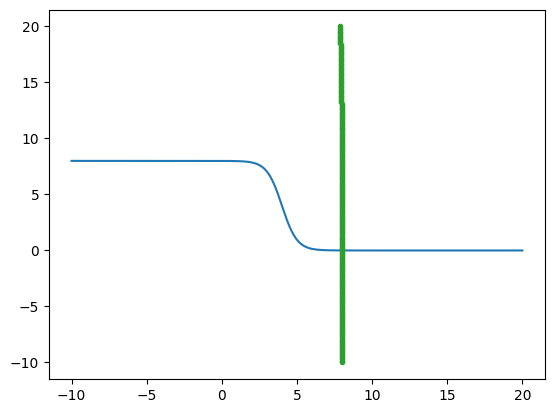

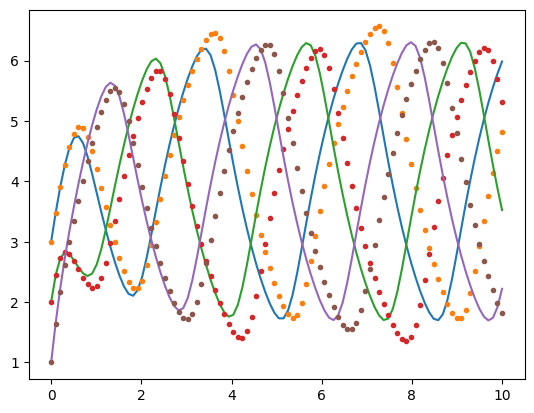

In [239]:
dim = 3
time_end = 10

gamma = - np.ones([dim])
Wout = 4 * np.eye(dim)
Win = np.zeros([dim, dim])
for i in range(1, dim):
    Win[i, i - 1] = -1
Win[0, dim - 1] = -1
bin, bout = 4 * np.ones([dim, 1]), 4 * np.ones([dim, 1])
# bin[2] = j

# knock down
# Win[1, :] = 0
# bout[1] = - np.tanh(bin[1]) * 4

Win_prime = Win.copy()
Win_prime[2, 0] = -0.1

node_3Drepr = make_nODE_from_parameters(gamma, Win=Win, bin=bin, Wout=Wout, bout=bout)
node_3Drepr_prime = make_nODE_from_parameters(gamma, Win=Win_prime, bin=bin, Wout=Wout, bout=bout)

# 10,0,.50
traj = node_3Drepr.trajectory(torch.tensor([10,0,.50]), time_interval=[0,time_end], n_evals=time_end*10)
traj_prime = node_3Drepr_prime.trajectory(torch.tensor([10,0,.50]), time_interval=[0,time_end], n_evals=time_end*10)
# print(node_3Drepr)
# print(node_3Drepr_prime)

def x1(x3):
    return Wout[0,0] * np.tanh(Win[0, 2] * x3 + bin[0]) + bout[0]

def x3(x1):
    return Wout[2,2] * np.tanh(Win[2, 0] * x1 + bin[2]) + bout[2]

def x3_prime(x1):
    return Wout[2,2] * np.tanh(Win_prime[2, 0] * x1 + bin[2]) + bout[2]

x1_plot = np.linspace(-10, 20, 200)
x3_plot = np.linspace(-10, 20, 200)
plt.plot(x3_plot, x1(x3_plot))
plt.plot(x3(x1_plot), x1_plot)
plt.plot(x3_prime(x1_plot), x1_plot, '.')
plt.show()

time = np.linspace(0, time_end, traj.size()[0])
for i in range(traj.size()[1]):
    plt.plot(time[:], traj[:,i].detach().numpy())
    plt.plot(time[:], traj_prime[:,i].detach().numpy(), '.')
plt.savefig('withoutKD')
plt.show()

Knock down by repressing the second gene (aka setting b_out[2] large and negative)

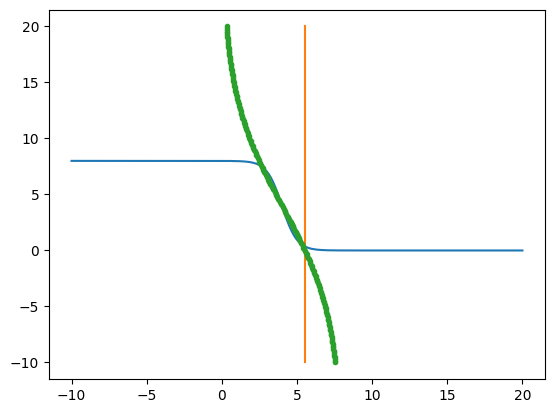

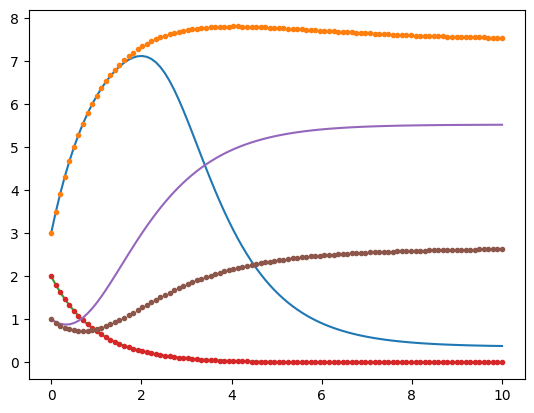

In [238]:
bin[2] = 0.4

# knock down
Win[1, :] = 0
bout[1] = - np.tanh(bin[1]) * 4

Win_prime = Win.copy()
Win_prime[2, 0] = -0.1

node_3Drepr = make_nODE_from_parameters(gamma, Win=Win, bin=bin, Wout=Wout, bout=bout)
node_3Drepr_prime = make_nODE_from_parameters(gamma, Win=Win_prime, bin=bin, Wout=Wout, bout=bout)

traj = node_3Drepr.trajectory(torch.tensor([10,0,.50]), time_interval=[0,time_end], n_evals=time_end*10)
traj_prime = node_3Drepr_prime.trajectory(torch.tensor([10,0,.50]), time_interval=[0,time_end], n_evals=time_end*10)

def x1(x3):
    return Wout[0,0] * np.tanh(Win[0, 2] * x3 + bin[0]) + bout[0]

def x3(x1):
    return Wout[2,2] * np.tanh(Win[2, 0] * x1 + bin[2]) + bout[2]

def x3_prime(x1):
    return Wout[2,2] * np.tanh(Win_prime[2, 0] * x1 + bin[2]) + bout[2]

x1_plot = np.linspace(-10, 20, 200)
x3_plot = np.linspace(-10, 20, 200)
plt.plot(x3_plot, x1(x3_plot))
plt.plot(x3(x1_plot), x1_plot)
plt.plot(x3_prime(x1_plot), x1_plot, '.')
plt.show()

time = np.linspace(0, time_end, traj.size()[0])
for i in range(traj.size()[1]):
    plt.plot(time[:], traj[:,i].detach().numpy())
    plt.plot(time[:], traj_prime[:,i].detach().numpy(), '.')
plt.savefig('withKD')
plt.show()